# 1. ICLL

This notebook explores the implementation of ICLL (Imbalanced Classification via Layered Learning [1]). The three steps to its implementation are:

- Dimensionality reduction for cluster build-up
- ICLL
- Explainability: understand the original drivers for RSV positivity from the reduced features


[1]: Cerqueira, V., Torgo, L., Branco, P., & Bellinger, C. (2023). Automated imbalanced classification via layered learning. Machine Learning, 112(6), 2083-2104.

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
import gower
import prince
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.linear_model import LogisticRegression


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *

In [4]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

<module 'auxFuns.modelling' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\modelling.py'>

In [6]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

In [7]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [8]:
df1 = rsv_predictors_df_v2[selected_features_v2]
df1.shape, df1.columns

((86058, 21),
 Index(['n_tests_that_day', 'sine', 'cosine', 'previous_test_daydiff',
        'Bronchitis', 'CCI', 'Acute_upper_respiratory_infection',
        'n_immunodeficiencies', 'n_symptoms', 'healthcare_seeking',
        'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
        'key_comorbidities', 'Pneumonia', 'season', 'month_of_the_test',
        'multiple_tests', 'BPA', 'BPAI', 'RSV_test_result'],
       dtype='object'))

## 1. Dimensionality reduction via FAMD

In [9]:
# Initialize the FAMD model and transform data to the new components
random_seed = 42
n_components = 3

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(df1)

df_transformed = famd.transform(df1)

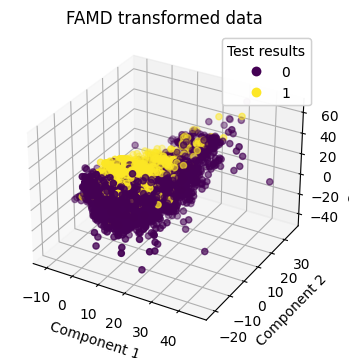

In [19]:
# Plot of the newly created data, indicating the presence of positive and negative tests

# Ensure both df1 and df_transformed present the same records in the same order
df1 = df1.sort_index()
df_transformed = df_transformed.sort_index()
assert all(df1.index == df_transformed.index), "The indices of df1 and df_transformed do not match."

df_transformed['RSV_test_result'] = [1 if label == 'Positive' else 0 for label in df1['RSV_test_result']]

# Plot of the transformed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_transformed[0], df_transformed[1], df_transformed[2], c=df_transformed['RSV_test_result'], cmap='viridis')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Test results")
ax.add_artist(legend1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('FAMD transformed data')
plt.show()


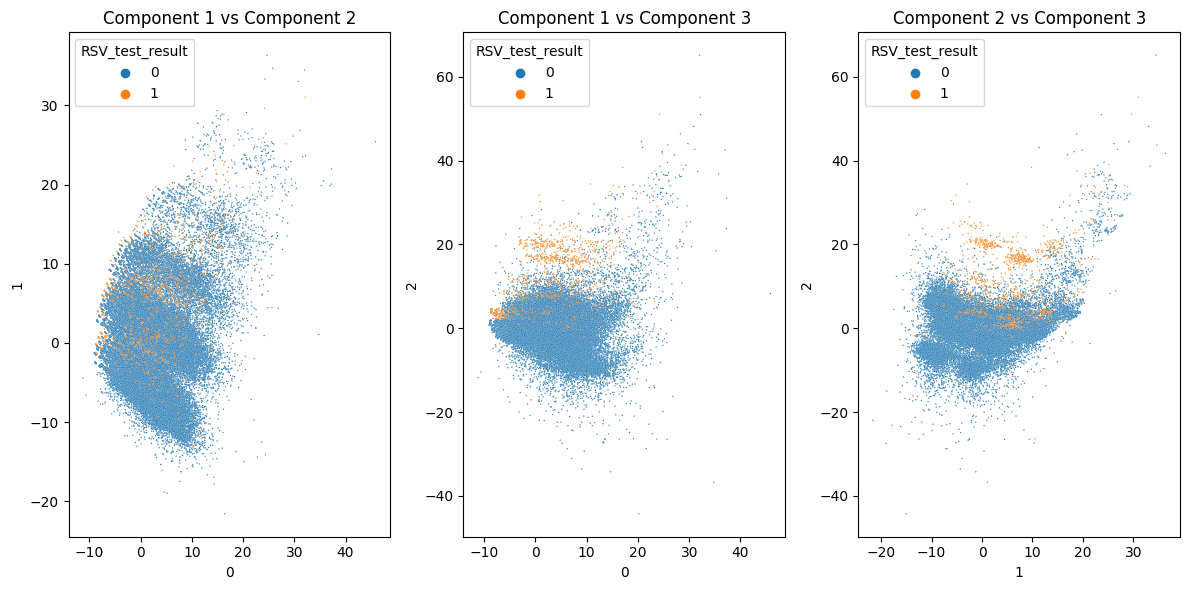

In [24]:
# For clarity, let us plot the 3 different planes
f, axes = plt.subplots(1, 3, figsize=(12, 6))

# Two-dimensional plots
sns.scatterplot(data=df_transformed, x=0, y=1, hue='RSV_test_result', ax=axes[0], s = 1)
axes[0].set_title('Component 1 vs Component 2')

sns.scatterplot(data=df_transformed, x=0, y=2, hue='RSV_test_result', ax=axes[1], s = 1)
axes[1].set_title('Component 1 vs Component 3')

sns.scatterplot(data=df_transformed, x=1, y=2, hue='RSV_test_result', ax=axes[2], s = 1)
axes[2].set_title('Component 2 vs Component 3')

plt.tight_layout()

In the newly created components, positive and negative test results seem to be very much separable. Let us try a simple initial model to evaluate this assumption.

In [31]:
df_modelling = df_transformed[[0,1,2,'RSV_test_result']]

X = df_modelling.drop(['RSV_test_result'], axis=1)
y = df_modelling['RSV_test_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42,
                                                        stratify= y)

In [35]:
cost_sensitive = False
if cost_sensitive:
    weight_dict = {0: 1, 1: 5}
    model_class = RandomForestClassifier(class_weight= weight_dict, random_state= random_seed)
else:
    model_class = RandomForestClassifier(class_weight= None, random_state= random_seed)
    
param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, average='binary', pos_label = 1)
n_cv_folds = 5

model1 = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train, y_train = y_train)

Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 14}
Best training f1-score:  0.629550779493368


Optimal threshold: 0.29
Optimal f1: 0.6720160481444333


AUC Score: 0.9489431744067334
Precision / Positive predictive value: 0.7188841201716738
Specificity: 0.9921467537917391
Recall / sensitivity: 0.6308851224105462
Negative predictive value: 0.9882957124089334
Accuracy: 0.9810016267720195
F-1: 0.6720160481444333
Precision-Recall AUC: 0.7228053037006135


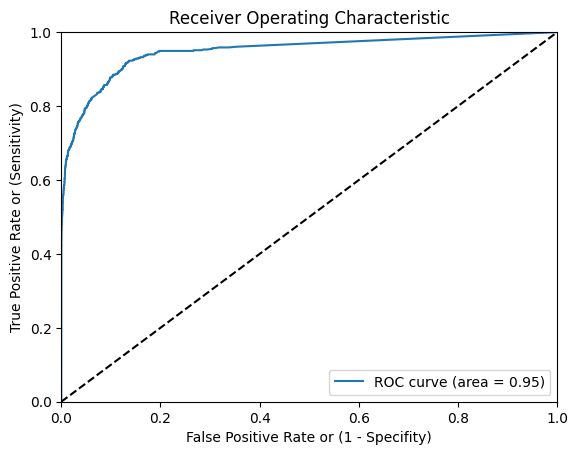

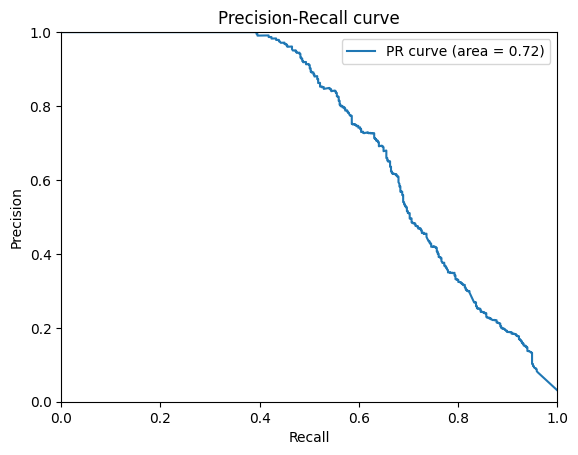

In [38]:
# y_test is brought back to the Negative/Positive notation for consistency
aux_y_test = ['Positive' if numeric_label == 1 else 'Negative' for numeric_label in y_test]

optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test, y_test = aux_y_test)

__,__,__,__,__,__,f1,__ = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test, y_test = aux_y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = True, print_pr = True)


The use of this newly-created components already produces a high performing model. Let us explore the use of ICLL for better understanding of the data.

## 2. ICLL implementation
ICLL presents two stages:
- First, the clustering of records
- Second, the build-up of 'layers' according to these clusters. Some clusters are defined as 'easy to predict' and others are the decision boundaries'

In [39]:
# Clustering of the observations, trying to clearly identify the decision boundaries